# EDA

In [ ]:
import pandas as pd
import numpy as np
import warnings
import geocoder
import geopy.distance
import requests
import json
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

### Read data into dataframes

In [108]:
df = pd.read_csv('../data/silvercar_reservations.csv')
df_users = pd.read_csv('../data/silvercar_users.csv')
df_promos = pd.read_csv('../data/silvercar_promotions.csv', encoding="ISO-8859-1")
df_promo_codes = pd.read_csv('../data/silvercar_promo_codes.csv', encoding="ISO-8859-1")
df_locations = pd.read_csv('../data/silvercar_locations.csv', encoding="ISO-8859-1")

#### Change pandas and numpy display for interpretability

In [4]:
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions.float_format = '{:.2f}'.format

In [5]:
df.head()

,id,pickup,dropoff,user_id,status,confirmation_token,created_at,updated_at,booked_price,current_state,...,publisher_id,cancelled_at,local_rental,booked_by_id,awards_referral_bonus,extole_conversion_id,potential_local_rental,claimed_at,customer_modifiable,credit_card_id
0,89,41288.29,41289.40,12.00,nan,5B23231DC0,41269.81,41417.80,nan,cancelled,...,NaN,nan,0,nan,0,nan,nan,nan,1,nan
1,91,41307.79,41308.79,49.00,nan,9A10C66F0C,41269.85,41417.80,nan,cancelled,...,NaN,nan,0,nan,0,nan,nan,nan,1,nan
2,93,41297.42,41310.83,51.00,nan,157C8653CA,41269.87,41417.80,nan,cancelled,...,NaN,nan,0,nan,0,nan,nan,nan,1,nan
3,94,41291.54,41293.83,45.00,nan,C48194AA4F,41269.91,41417.80,nan,cancelled,...,NaN,nan,0,nan,0,nan,nan,nan,1,nan
4,95,41290.98,41291.79,55.00,nan,AABEB48B94,41269.94,41702.08,nan,finished,...,NaN,nan,0,nan,0,nan,nan,nan,1,nan


#### Check null values

In [6]:
np.sum(df.isnull())

id                                                 0
pickup                                             0
dropoff                                            0
user_id                                            1
status                                        462564
confirmation_token                                 0
created_at                                         0
updated_at                                         0
booked_price                                  439186
current_state                                      0
booked_daily_rate                             439186
confirmed                                          0
reservation_type_id                                0
pickup_location_id                                 0
dropoff_location_id                                0
rental_agreement_id                           193945
promo_code_id                                 265766
actual_pickup                                 193823
actual_dropoff                                

## Feature engineering
#### Convert datetime columns

In [7]:
def get_datetime(series):
    return pd.to_datetime('1899-12-30') + pd.to_timedelta(series, 'D')

df["pickup"] = get_datetime(df["pickup"])
df["dropoff"] = get_datetime(df["dropoff"])
df["created_at"] = get_datetime(df["created_at"])
df["updated_at"] = get_datetime(df["updated_at"])

In [8]:
print(df["created_at"].min())
print(df["created_at"].max())

2012-12-26 19:31:35.904000
2017-12-14 19:02:15.935999999


In [9]:
print(np.any(df["dropoff"] < df["pickup"]))
print(np.any(df["updated_at"] < df["created_at"]))

False
True


In [10]:
df[df["updated_at"] < df["created_at"]].head()

,id,pickup,dropoff,user_id,status,confirmation_token,created_at,updated_at,booked_price,current_state,...,publisher_id,cancelled_at,local_rental,booked_by_id,awards_referral_bonus,extole_conversion_id,potential_local_rental,claimed_at,customer_modifiable,credit_card_id
322350,331435,2017-01-12 01:59:59.712,2017-01-14 16:30:00.000,354184.00,nan,24653AAB27,2017-01-02 00:22:44.255999999,2017-01-02 00:22:32.160,nan,cancelled,...,NaN,42737.02,0,nan,0,nan,nan,nan,1,nan
323180,332355,2017-01-10 13:30:00.000,2017-01-13 01:00:00.288,353178.00,nan,E053FF8619,2017-01-04 15:38:12.192000000,2017-01-04 15:36:14.688,nan,cancelled,...,NaN,42739.65,0,nan,0,nan,nan,nan,1,nan
323183,332362,2017-01-04 16:59:59.712,2017-01-06 16:59:59.712,354324.00,nan,7461DD4A29,2017-01-04 15:44:28.032000000,2017-01-04 15:43:18.912,nan,cancelled,...,NaN,42739.66,0,nan,0,nan,nan,nan,1,nan
323554,332767,2017-01-06 19:00:00.288,2017-01-08 19:00:00.288,355171.00,nan,D6813D84F2,2017-01-05 06:06:28.800000000,2017-01-05 06:04:53.760,nan,cancelled,...,NaN,42740.25,0,nan,0,nan,1.00,nan,1,nan
323562,332775,2017-01-05 19:00:00.288,2017-01-08 19:00:00.288,293501.00,nan,CDDC40C1FE,2017-01-05 07:04:52.320000000,2017-01-05 07:02:39.264,nan,cancelled,...,NaN,42740.29,0,nan,0,nan,nan,nan,1,nan


### Create time to pickup and trip duration features in days 

In [11]:
df["time_to_pickup"] = (df["pickup"] - df["created_at"]).dt.total_seconds() / 86400
df["trip_duration"] = (df["dropoff"] - df["pickup"]).dt.total_seconds() / 86400

Create binary variables for whether or not the reservation was made with a promo code and whether or not
the car's being picked up and dropped off in the same place

In [12]:
df["used_promo"] = (df["promo_code_id"].notnull()).astype(int)
df["same_location"] = (df["pickup_location_id"] == df["dropoff_location_id"]).astype(int)

In [13]:
df["same_location"].sum() / df["same_location"].count()

0.99999351441097883

#### Look at the current state variable, which tells us if the ride was cancelled or not

In [14]:
df["current_state"].value_counts()

finished                      268088
cancelled                     162600
no_showed                      23013
booked                          6172
payment_declined_cancelled      2065
started                          621
pending_agreement                  5
Name: current_state, dtype: int64

#### Make a separate booked data frame for dashboard

In [15]:
mask = df["pickup"] > df["created_at"].max()
df_booked = df[df["current_state"] == "booked"]

In [16]:
df_booked.head()

,id,pickup,dropoff,user_id,status,confirmation_token,created_at,updated_at,booked_price,current_state,...,awards_referral_bonus,extole_conversion_id,potential_local_rental,claimed_at,customer_modifiable,credit_card_id,time_to_pickup,trip_duration,used_promo,same_location
347533,358808,2017-12-28 16:59:59.712,2018-01-02 17:30:00.288,374628.00,nan,28E9FED670,2017-03-07 07:32:45.024,2017-08-16 21:19:28.128,nan,booked,...,0,nan,nan,nan,1,nan,296.39,5.02,1,1
358862,370138,2018-04-20 18:29:59.712,2018-04-23 19:00:00.288,201849.00,nan,B003C40F47,2017-04-05 09:27:33.696,2017-11-02 14:48:40.896,nan,booked,...,0,6405450000000000000.00,nan,nan,1,nan,380.38,3.02,1,1
391915,403193,2017-12-17 22:00:00.288,2017-12-19 01:00:00.288,251806.00,nan,EF7EBFC9DC,2017-06-27 02:46:20.928,2017-10-08 20:44:19.104,nan,booked,...,0,nan,nan,nan,1,nan,173.80,1.12,0,1
392235,403513,2017-12-15 16:59:59.712,2017-12-19 16:59:59.712,413056.00,nan,0115DEE903,2017-06-27 21:47:52.800,2017-06-27 22:00:02.880,nan,booked,...,0,nan,nan,nan,1,nan,170.80,4.00,0,1
393171,404449,2017-12-16 15:29:59.712,2017-12-22 21:00:00.000,62675.00,nan,78CAF730D6,2017-06-29 22:38:22.848,2017-12-11 15:09:14.688,nan,booked,...,0,nan,1.00,nan,1,nan,169.70,6.23,0,1


In [17]:
np.sum((df_booked["pickup"].dt.month == 1) & (df_booked["pickup"].dt.year == 2018))

1534

1,500 reservations can be displayed in the dashboard for the following month (01/18)

### Check if no shows have same behavior as users who cancel

In [18]:
df = df[df["current_state"].isin(["finished", "cancelled", "no_showed"])]
df["current_state"] = df["current_state"].map({"finished": 0, "cancelled": 1, "no_showed": 2})

In [19]:
df.groupby("current_state").mean().T

current_state,0,1,2
id,243490.29,216578.76,238007.63
user_id,195434.73,189254.30,225236.14
status,nan,nan,nan
booked_price,217.03,232.09,213.77
booked_daily_rate,140.78,140.54,139.14
confirmed,0.00,0.00,0.00
reservation_type_id,2.83,2.46,2.74
pickup_location_id,7.91,8.54,8.11
dropoff_location_id,7.91,8.54,8.11
rental_agreement_id,22.56,12.83,14.00


#### No shows exhibit some characteristics of users who finish rides, so I'm going to drop them for now

In [20]:
df = df[df["current_state"].isin([0, 1])]
df.rename(columns={"current_state": "cancelled"}, inplace=True)

#### Look at descriptive stats

In [21]:
df.describe().T

In [22]:
df.corr().T

In [23]:
df.groupby("cancelled").mean().T

cancelled,0,1
id,243490.29,216578.76
user_id,195434.73,189254.30
status,nan,nan
booked_price,217.03,232.09
booked_daily_rate,140.78,140.54
confirmed,0.00,0.00
reservation_type_id,2.83,2.46
pickup_location_id,7.91,8.54
dropoff_location_id,7.91,8.54
rental_agreement_id,22.56,12.83


### Look at booking application and user agent to see if they have any predictive power

In [24]:
df["booking_application"].value_counts()

iphone-appstore     162149
web                 133620
web-desktop          71439
android              26515
gds                  18826
web-mobile            9969
web-tablet            1961
iphone-concierge       545
iphone-debug           127
kiosk                  102
Name: booking_application, dtype: int64

In [25]:
mask = df["cancelled"] == 1
df["booking_application"][mask].value_counts() / df["booking_application"][mask].count()

web                0.43
iphone-appstore    0.27
web-desktop        0.16
android            0.06
gds                0.05
web-mobile         0.02
web-tablet         0.00
iphone-concierge   0.00
iphone-debug       0.00
kiosk              0.00
Name: booking_application, dtype: float64

In [26]:
df["booking_application"][~mask].value_counts() / df["booking_application"][~mask].count()

iphone-appstore    0.45
web                0.24
web-desktop        0.17
android            0.07
gds                0.04
web-mobile         0.02
web-tablet         0.00
iphone-concierge   0.00
kiosk              0.00
iphone-debug       0.00
Name: booking_application, dtype: float64

Looks like users are more likely to cancel if they book on the web. This is probably because app users have accounts
set up already, so this would be strongly correlated with the "booked as guest" feature

In [27]:
df["booking_user_agent"] = df["booking_user_agent"].str.split("/", expand=True)[0]

In [28]:
df["booking_user_agent"].value_counts()

Mozilla           216977
driver             89656
Silvercar          55926
Android            25305
driverapp          17238
okhttp              1211
SilvercarKiosk       102
Opera                  6
Driver-ios             3
Dealerkit              1
iPhone OS              1
Name: booking_user_agent, dtype: int64

In [29]:
df["booking_user_agent"][mask].value_counts() / df["booking_user_agent"][mask].count()

Mozilla          0.66
driver           0.16
Silvercar        0.09
Android          0.06
driverapp        0.03
okhttp           0.00
Opera            0.00
SilvercarKiosk   0.00
Driver-ios       0.00
Dealerkit        0.00
iPhone OS        0.00
Name: booking_user_agent, dtype: float64

In [30]:
df["booking_user_agent"][~mask].value_counts() / df["booking_user_agent"][~mask].count()

Mozilla          0.46
driver           0.26
Silvercar        0.16
Android          0.07
driverapp        0.05
okhttp           0.00
SilvercarKiosk   0.00
Opera            0.00
Name: booking_user_agent, dtype: float64

Booking user agent has a lot of null values, so I'm going to ignore it for now because it doesn't appear to be
a good enough predictor to worry about imputing values

#### Look at referral bonuses, local rentals, and guest rentals

In [31]:
df["awards_referral_bonus"].value_counts()

0    418399
1     12289
Name: awards_referral_bonus, dtype: int64

In [32]:
df["local_rental"].value_counts()

0    418682
1     12006
Name: local_rental, dtype: int64

In [33]:
df["created_as_guest"].value_counts()

0    341658
1     89030
Name: created_as_guest, dtype: int64

### Engineer new date related features

In [34]:
df["pickup_dow"] = df["pickup"].dt.dayofweek
df["pickup_month"] = df["pickup"].dt.month
df["pickup_year"] = df["pickup"].dt.year

In [35]:
df.groupby(["cancelled", "pickup_dow"])["booked_price"].mean()

cancelled  pickup_dow
0          0            226.30
           1            194.63
           2            206.10
           3            214.58
           4            232.47
           5            232.43
           6            256.33
1          0            236.48
           1            215.37
           2            212.47
           3            232.96
           4            244.49
           5            241.20
           6            271.83
Name: booked_price, dtype: float64

In [36]:
df.groupby("pickup_dow")["cancelled"].mean()

pickup_dow
0   0.33
1   0.32
2   0.34
3   0.38
4   0.43
5   0.44
6   0.41
Name: cancelled, dtype: float64

In [37]:
df["weekend_pickup"] = (df["pickup_dow"].isin([4, 5, 6])).astype(int)

In [38]:
df.groupby("pickup_month")["cancelled"].mean()

pickup_month
1    0.42
2    0.39
3    0.36
4    0.36
5    0.36
6    0.37
7    0.39
8    0.37
9    0.35
10   0.35
11   0.37
12   0.45
Name: cancelled, dtype: float64

In [39]:
df["dec_jan_pickup"] = (df["pickup_dow"].isin([1, 12])).astype(int)

In [40]:
df.groupby("pickup_year")["cancelled"].mean()

pickup_year
2013   0.53
2014   0.45
2015   0.42
2016   0.33
2017   0.34
2018   1.00
Name: cancelled, dtype: float64

In [41]:
df[["first_rental", "new_customer", "repeat_customer"]] = pd.get_dummies(df["reservation_frequency"])

In [42]:
df.groupby("cancelled")[["first_rental", "new_customer", "repeat_customer"]].mean()

,first_rental,new_customer,repeat_customer
cancelled,,,
0,0.15,0.36,0.47
1,0.11,0.29,0.21


In [43]:
df["new_customer"] = df["repeat_customer"] == 0
df.drop(["first_rental", "repeat_customer"], axis=1, inplace=True)

### Look at location data

In [83]:
df_locations = df[["pickup_location_id", "cancelled"]].join(df_locations, on="pickup_location_id")

In [89]:
df_locations.groupby("time_zone")["cancelled"].mean()

time_zone
cst   0.36
est   0.37
mst   0.38
pst   0.40
Name: cancelled, dtype: float64

In [94]:
df_locations.groupby("in_state")["cancelled"].mean()

in_state
Arizona      0.48
California   0.38
Colorado     0.35
Florida      0.35
Illinois     0.38
Nevada       0.50
New Jersey   0.42
New York     0.36
Texas        0.36
Name: cancelled, dtype: float64

In [95]:
df_locations.groupby("in_city")["cancelled"].mean()

in_city
Austin           0.38
Chandler         0.48
Chicago          0.38
Dallas           0.32
Denver           0.35
Ft. Lauderdale   0.60
Houston          0.33
Las Vegas        0.50
Los Angeles      0.38
Miami            0.35
New York City    0.36
Newark           0.42
San Francisco    0.49
Name: cancelled, dtype: float64

### Look at promos

In [126]:
df_codes = df_promo_codes[["id", "promotion_id"]].set_index("id")
df_promos_new = df_codes.join(df_promos[["value", "id"]].set_index("id"), how="left")
df_promos_new.drop("promotion_id", axis=1, inplace=True)

In [127]:
df_promos_new = df[["promo_code_id", "cancelled"]].join(df_promos_new, how="left", on="promo_code_id")
df_promos_new.drop("promo_code_id", axis=1, inplace=True)
df_promos_new.value.fillna(0, inplace=True)

In [129]:
df_promos_new = df_promos_new[df_promos_new["value"] <= 100]
df_promos_new["value"] = pd.cut(df_promos_new["value"], 5)

In [132]:
df_promos_new.groupby("value").mean()

,cancelled
value,
"(-0.1, 20.0]",0.38
"(20.0, 40.0]",0.22
"(40.0, 60.0]",0.24
"(60.0, 80.0]",0.34
"(80.0, 100.0]",0.19


### Look at users

In [352]:
df_users_new = df_users.set_index("id")
df_users_new = df[["cancelled", "user_id"]].join(df_users_new, how="left", on="user_id")
df_users_new.head()

,cancelled,user_id,remember_created_at,sign_in_count,current_sign_in_at,last_sign_in_at,current_sign_in_ip,last_sign_in_ip,password_salt,confirmation_token,...,referral_code,referred_at,signup_channel,manually_confirmed,facebook_user_id,google_user_id,photo_url,photo_thumbnail_url,unconfirmed_email,active
0,1,12.00,NaN,374.00,42514.25,42514.24,54.237.62.169,54.159.211.167,3WyVx34E2ocS4HCjTSQm,qfFxXgB4gHjBxBgLxDq4,...,SJACOB,41949.20,NaN,0.00,nan,nan,NaN,NaN,NaN,1.00
1,1,49.00,NaN,128.00,41294.13,41294.13,208.54.32.141,208.54.32.141,JCqmAyb7YxX7vxbL3qTq,NaN,...,TDROID1,nan,NaN,0.00,nan,nan,NaN,NaN,NaN,1.00
2,1,51.00,NaN,nan,nan,nan,NaN,NaN,NaN,NaN,...,NaN,nan,NaN,nan,nan,nan,NaN,NaN,NaN,nan
3,1,45.00,NaN,43.00,41269.92,41269.92,216.16.192.210,216.16.192.210,BjsByo5FDsru9ycfWinW,NaN,...,QSILVER,nan,NaN,0.00,nan,nan,NaN,NaN,NaN,1.00
4,0,55.00,NaN,56.00,41651.96,41651.96,166.147.66.103,166.147.66.103,Wgqyc1nLAqm69pGxaxLN,NaN,...,TSCOGGINS,nan,NaN,0.00,nan,nan,NaN,NaN,NaN,1.00


In [353]:
np.sum(df_users_new.isnull())

cancelled                              0
user_id                                0
remember_created_at               428079
sign_in_count                         58
current_sign_in_at                 30640
last_sign_in_at                    30640
current_sign_in_ip                 30640
last_sign_in_ip                    30640
password_salt                      22823
confirmation_token                381944
confirmed_at                       23198
confirmation_sent_at                 305
authentication_token               37848
created_at                            58
updated_at                            58
is_gds_user                           58
loyalty_number                        61
terms_and_conditions_id              654
privacy_policy_id                    654
guest_reservation_link_clicked        58
silvercar_opted_in_at              40000
silvercar_opted_out_at            408918
partner_opted_in_at               241081
partner_opted_out_at              270111
referred_by_id  

#### Calculate days since last sign in

In [354]:
df_users_new["last_sign_in_at"] = get_datetime(df_users_new["last_sign_in_at"])

In [355]:
df_users_new["days_since_sign_in"] = (pd.to_datetime('2017-12-14') - df_users_new["last_sign_in_at"]).dt.total_seconds() / 86400

#### Create binary variable that is true if the user used a referral code when signing up for the first time

In [356]:
df_users_new["used_referral"] = ~df_users_new["referral_code"].isnull()

#### Use IP to roughly check if distance to pick up location has predictive power

In [537]:
df_users_sample = df_users_new.sample(10000)

In [538]:
def get_ip_lat_lng(ip):
    if isinstance(ip, str):
        url = 'http://freegeoip.net/json/{}'.format(ip)
        j = json.loads(requests.get(url).text)
        return [j['latitude'], j['longitude']]

In [331]:
# def get_ip_lat_lng(ip):
#     if isinstance(ip, str):
#         return geocoder.ip(ip).latlng

In [256]:
def get_city_lat_lng(city_state):
    if isinstance(city_state, str):
        return geocoder.google(city_state).latlng

In [ ]:
df_users_sample["user_lat_lng"] = df_users_sample["last_sign_in_ip"].apply(get_ip_lat_lng)

In [ ]:
user_lat_lng = df_users_sample
# df_users_sample = df_users_new[df_users_new.user_id.isin(user_lat_lng.index)]
# df_users_sample = df_users_sample.join(user_lat_lng, on="user_id")

In [252]:
df_locations["city_state"] = df_locations["in_city"] + ', ' + df_locations["in_state"]

In [257]:
df_locations["lat_lng"] = df_locations["city_state"].apply(get_city_lat_lng)

In [457]:
df_locations_new = df_locations[["lat_lng", "id"]].set_index("id")
df_locations_new = df[["pickup_location_id", "user_id"]].join(df_locations_new, on="pickup_location_id")
df_locations_new.drop("pickup_location_id", axis=1, inplace=True)

In [458]:
df_locations_new.set_index("user_id", inplace=True)

In [459]:
df_users_new2 = df_users_sample.join(df_locations_new, how="left", on="user_id", lsuffix="_user")

In [474]:
def distance_between_coords(row):
    if isinstance(row["lat_lng"], list) & isinstance(row["lat_lng_user"], list):
        return geopy.distance.vincenty(row["lat_lng"], row["lat_lng_user"]).miles

In [475]:
df_users_new2["distance_to_pickup"] = df_users_new2.apply(lambda row: distance_between_coords(row), axis=1)

In [476]:
df_users_new2.sort_values("distance_to_pickup", ascending=False)

,cancelled,user_id,remember_created_at,sign_in_count,current_sign_in_at,last_sign_in_at,current_sign_in_ip,last_sign_in_ip,password_salt,confirmation_token,...,google_user_id,photo_url,photo_thumbnail_url,unconfirmed_email,active,days_since_sign_in,used_referral,lat_lng_user,lat_lng,distance_to_pickup
84485,0,106002.00,NaN,69.00,42272.68,2015-09-25 16:19:12,24.14.148.79,24.14.148.79,rUegxpYp7zXrgs7MfSxv,NaN,...,nan,NaN,NaN,NaN,1.00,810.32,True,"[22.2833, 114.1833]","[32.7766642, -96.79698789999999]",8130.39
84485,0,106002.00,NaN,69.00,42272.68,2015-09-25 16:19:12,24.14.148.79,24.14.148.79,rUegxpYp7zXrgs7MfSxv,NaN,...,nan,NaN,NaN,NaN,1.00,810.32,True,"[22.2833, 114.1833]","[32.7766642, -96.79698789999999]",8130.39
95540,0,106002.00,NaN,69.00,42272.68,2015-09-25 16:19:12,24.14.148.79,24.14.148.79,rUegxpYp7zXrgs7MfSxv,NaN,...,nan,NaN,NaN,NaN,1.00,810.32,True,"[22.2833, 114.1833]","[32.7766642, -96.79698789999999]",8130.39
95540,0,106002.00,NaN,69.00,42272.68,2015-09-25 16:19:12,24.14.148.79,24.14.148.79,rUegxpYp7zXrgs7MfSxv,NaN,...,nan,NaN,NaN,NaN,1.00,810.32,True,"[22.2833, 114.1833]","[32.7766642, -96.79698789999999]",8130.39
449649,0,224897.00,NaN,60.00,43081.71,2017-12-12 17:02:24,108.162.219.215,108.162.219.215,32yD2VLJWccrCzymuC2e,NaN,...,nan,NaN,NaN,NaN,1.00,1.29,True,"[35.685, 139.7514]","[40.6781784, -73.9441579]",6758.51
403388,0,424026.00,NaN,63.00,42944.72,2017-07-28 17:16:48,172.68.141.179,172.68.141.179,izb4pLivUsoNpJvfepR8,Qpby5P5HAXanNTZzw7Lx,...,nan,http://s3.amazonaws.com/production-silvercar-a...,http://s3.amazonaws.com/production-silvercar-a...,NaN,1.00,138.28,True,"[41.7667, 12.2333]","[37.7749295, -122.4194155]",6258.11
41918,0,38295.00,NaN,88.00,42481.93,2016-04-08 03:50:24,54.237.62.169,98.171.176.49,vgr7xfoMGzzc4oHxqQRp,NaN,...,nan,NaN,NaN,NaN,1.00,614.84,True,"[-34.8581, -56.1708]","[34.0522342, -118.2436849]",6212.42
31300,0,38295.00,NaN,88.00,42481.93,2016-04-08 03:50:24,54.237.62.169,98.171.176.49,vgr7xfoMGzzc4oHxqQRp,NaN,...,nan,NaN,NaN,NaN,1.00,614.84,True,"[-34.8581, -56.1708]","[34.0522342, -118.2436849]",6212.42
37544,0,38295.00,NaN,88.00,42481.93,2016-04-08 03:50:24,54.237.62.169,98.171.176.49,vgr7xfoMGzzc4oHxqQRp,NaN,...,nan,NaN,NaN,NaN,1.00,614.84,True,"[-34.8581, -56.1708]","[34.0522342, -118.2436849]",6212.42
41909,1,38295.00,NaN,88.00,42481.93,2016-04-08 03:50:24,54.237.62.169,98.171.176.49,vgr7xfoMGzzc4oHxqQRp,NaN,...,nan,NaN,NaN,NaN,1.00,614.84,True,"[-34.8581, -56.1708]","[34.0522342, -118.2436849]",6212.42


In [477]:
df_users_new2.groupby("cancelled").mean().T

cancelled,0,1
sign_in_count,2443.77,1955.37
current_sign_in_at,42965.05,42878.52
confirmed_at,41767.04,41927.27
confirmation_sent_at,41956.48,41983.80
created_at,41766.93,41933.87
updated_at,42969.04,42864.26
is_gds_user,0.00,0.01
terms_and_conditions_id,12.90,12.89
privacy_policy_id,9.10,11.74
guest_reservation_link_clicked,0.37,0.39


In [519]:
df_users_small = df_users_new2[df_users_new2["distance_to_pickup"] > 0]

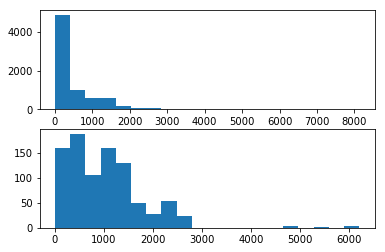

In [525]:
mask = df_users_small["cancelled"] == 1
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(df_users_small["distance_to_pickup"][~mask], bins=20)
ax2.hist(df_users_small["distance_to_pickup"][mask], bins=20)
fig.show()

# Model Building

In [112]:
# cols = ["user_id", "cancelled", "time_to_pickup", "reservation_frequency", "used_promo",
#       "trip_length"]

cols = df.columns[(df.dtypes != "object") & (df.dtypes != "datetime64[ns]") & (np.sum(df.isnull()) < 1000)]
df_model = df[cols]
df_model["promo_code_id"] = df["promo_code_id"]

In [113]:
df_codes = df_promo_codes[["id", "promotion_id"]].set_index("id")

In [114]:
df_promo_model = df_codes.join(df_promos[["value", "id"]].set_index("id"), how="left")

In [115]:
df_promo_model.drop("promotion_id", axis=1, inplace=True)

In [116]:
df_model = df_model.join(df_promo_model, how="left", on="promo_code_id")
df_model.drop("promo_code_id", axis=1, inplace=True)
df_model.value.fillna(0, inplace=True)

In [117]:
df_users_model = df_users[["sign_in_count", "is_gds_user", "id"]].set_index("id")
df_model = df_model.join(df_users_model, how="left", on="user_id")
df_model.drop("user_id", axis=1, inplace=True)

In [118]:
df_model.dropna(inplace=True)

In [119]:
df_model = df_model[df_model["value"] <= 100]
df_model["value"] = pd.cut(df_model["value"], 3, labels=[0, 1, 2])

In [121]:
df_model.groupby("value")["cancelled"].mean()

value
0   0.38
1   0.29
2   0.19
Name: cancelled, dtype: float64

In [53]:
y = df_model.pop("cancelled")
X_train, X_test, y_train, y_test = train_test_split(df_model, y)

In [54]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.63110078959591265

In [55]:
rf = RandomForestClassifier(max_depth=3, n_estimators=50)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.73298653042266604

In [60]:
# taken from churn case study solution
def plot_feature_importances(df, feature_importances):
    feat_scores = pd.DataFrame({'Mean Decrease Impurity' : feature_importances},
                           index=df.columns)
    feat_scores = feat_scores.sort_values(by='Mean Decrease Impurity')
    feat_scores.plot(kind='barh', figsize=(12,12))

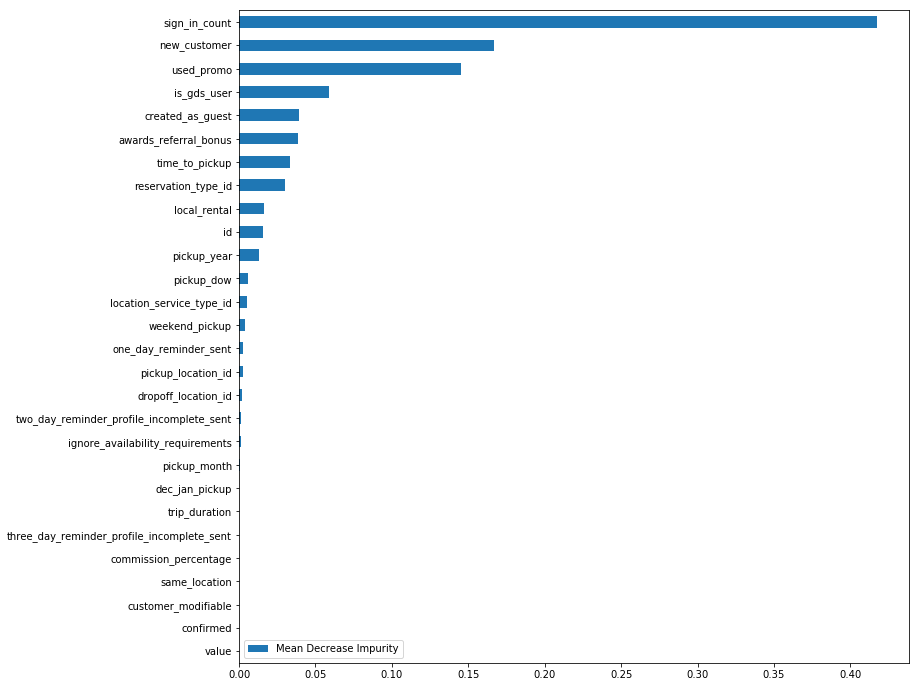

In [61]:
plot_feature_importances(df_model, rf.feature_importances_)

In [64]:
# stolen from sklearn's example
def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(np.arange(2), ["Finished", "Cancelled"], rotation=45)
    plt.yticks(np.arange(2), ["Finished", "Cancelled"])
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

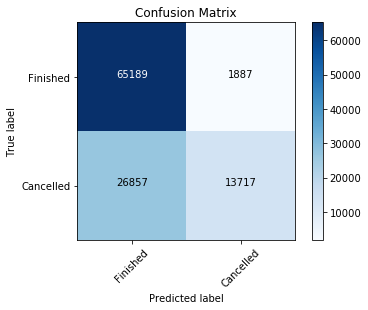

In [67]:
predictions = rf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)

In [57]:
gbc = GradientBoostingClassifier(n_estimators=50, max_depth=8, subsample=0.5, 
                                 max_features='auto', learning_rate=0.05)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [58]:
gbc.score(X_test, y_test)

0.80416163492800741

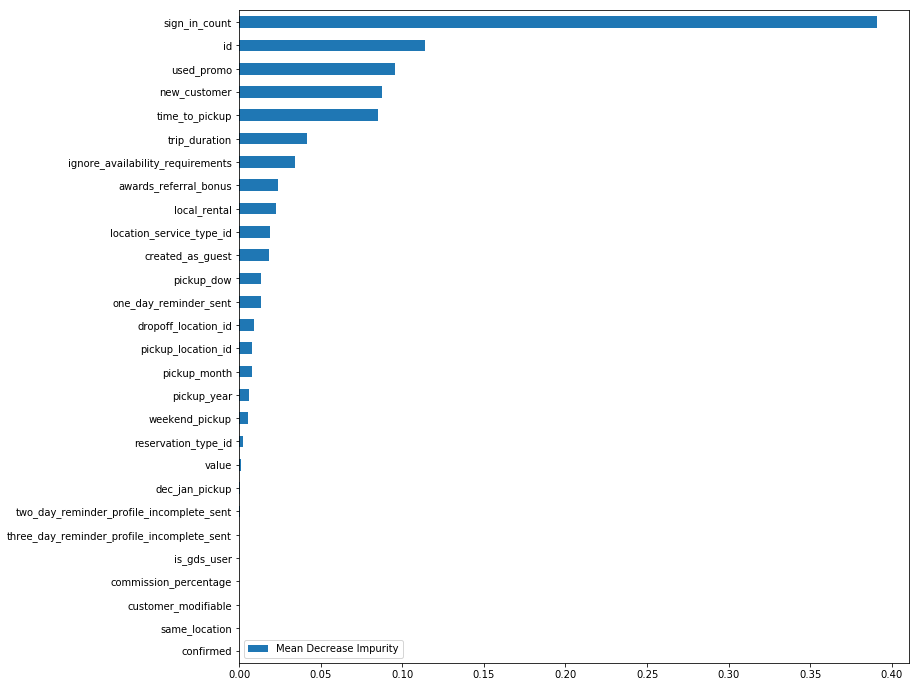

In [62]:
plot_feature_importances(df_model, gbc.feature_importances_)

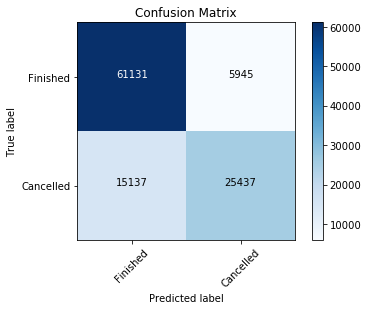

In [68]:
predictions = gbc.predict(X_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)